In [2]:
!pip install torchinfo

In [3]:
# import

import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torchinfo

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
from pytz import timezone

In [4]:
# 하이퍼파라미터 설정
RANDOM_SEED = 4242
BATCH_SIZE = 32
EPOCHS = 20
IMG_SIZE = 32
NUM_CLASSES = 10

# 하이퍼파리미터-학습률 스케줄링 설정
def lr_schedule(epoch):
    if epoch <= 2:
        lr = 5e-4
    elif epoch <= 5:
        lr = 2e-4
    elif epoch <= 9:
        lr = 5e-5
    else:
        lr = 1e-5
    return lr

In [5]:
# 모델의 정확도를 계산하는 함수
def get_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            probabilities = F.softmax(model(images), dim=-1)
            _, predicted_labels = torch.max(probabilities, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum()
    return correct_predictions.float() / total_predictions

In [6]:
# 학습 손실과 검증 손실을 시각화
def plot_loss(train_loss, val_loss):
    plt.style.use("grayscale")
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))
    ax.plot(train_loss, color="green", label="Training Loss")
    ax.plot(val_loss, color="red", label="Validation Loss")
    ax.set(title="Loss Over Epochs", xlabel="EPOCH", ylabel="LOSS")
    ax.legend()
    fig.show()
    plt.style.use("default")

In [7]:
# 모델 학습 함수
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [8]:
# 검증 데이터셋을 사용하여 모델의 성능을 평가
def validate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 순전파와 손실 기록하기
        logits = model(images)
        loss = criterion(logits, labels)
        total_loss += loss.item() * images.size(0)

    epoch_loss = total_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [9]:
# 전체 학습 루프
def training_loop(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    epochs,
    device,
    print_every=1,
):

    best_loss = 1e10
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        new_lr = lr_schedule(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr

        # training
        model, optimizer, train_loss = train(
            train_loader, model, criterion, optimizer, device
        )
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)

            print(
                datetime.now(timezone("Asia/Seoul")).time().replace(microsecond=0),
                "--- ",
                f"Epoch: {epoch}\t"
                f"Train loss: {train_loss:.4f}\t"
                f"Valid loss: {valid_loss:.4f}\t"
                f"Train accuracy: {100 * train_acc:.2f}\t"
                f"Valid accuracy: {100 * valid_acc:.2f}",
            )

    plot_loss(train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class ModifiedLeNet5(nn.Module):

    def __init__(self, num_classes):
        super(ModifiedLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        # 규칙에 따른 16개의 Conv2d 레이어를 생성합니다.
        self.conv3 = nn.ModuleList([nn.Conv2d(in_channels=len(rules), out_channels=1, kernel_size=5, stride=1) for rules in [
            [0, 1, 2],
            [1, 2, 3],
            [2, 3, 4],
            [3, 4, 5],
            [0, 4, 5],
            [0, 1, 5],
            [0, 1, 2, 3],
            [1, 2, 3, 4],
            [2, 3, 4, 5],
            [0, 3, 4, 5],
            [0, 1, 4, 5],
            [0, 1, 2, 5],
            [0, 1, 3, 4],
            [1, 2, 4, 5],
            [0, 2, 3, 5],
            [0, 1, 2, 3, 4, 5]
        ]])
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.fc6 = nn.Linear(120, 84)
        self.fc7 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.tanh(x)

        x = self.pool2(x)

        # 규칙에 따라 각 Conv3 레이어에 대해 입력을 선택하고 합성곱 연산을 수행합니다.
        rules = [
            [0, 1, 2],
            [1, 2, 3],
            [2, 3, 4],
            [3, 4, 5],
            [0, 4, 5],
            [0, 1, 5],
            [0, 1, 2, 3],
            [1, 2, 3, 4],
            [2, 3, 4, 5],
            [0, 3, 4, 5],
            [0, 1, 4, 5],
            [0, 1, 2, 5],
            [0, 1, 3, 4],
            [1, 2, 4, 5],
            [0, 2, 3, 5],
            [0, 1, 2, 3, 4, 5]
        ]

        conv3_results = []
        for i, rule in enumerate(rules):
            selected_inputs = torch.cat([x[:, idx:idx+1, :, :] for idx in rule], dim=1)
            conv3_results.append(self.conv3[i](selected_inputs))

        x = torch.cat(conv3_results, dim=1)
        x = F.tanh(x)

        x = self.pool4(x)

        x = self.conv5(x)
        x = F.tanh(x)

        x = x.view(x.size(0), -1)
        x = self.fc6(x)
        x = F.tanh(x)

        logits = self.fc7(x)

        return logits

# 예시로 10개의 클래스를 분류한다고 가정합니다.
NUM_CLASSES = 10
model = ModifiedLeNet5(NUM_CLASSES)
summary(model, input_size=(1, 1, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
ModifiedLeNet5                           [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─AvgPool2d: 1-2                         [1, 6, 14, 14]            --
├─ModuleList: 1-3                        --                        --
│    └─Conv2d: 2-1                       [1, 1, 10, 10]            76
│    └─Conv2d: 2-2                       [1, 1, 10, 10]            76
│    └─Conv2d: 2-3                       [1, 1, 10, 10]            76
│    └─Conv2d: 2-4                       [1, 1, 10, 10]            76
│    └─Conv2d: 2-5                       [1, 1, 10, 10]            76
│    └─Conv2d: 2-6                       [1, 1, 10, 10]            76
│    └─Conv2d: 2-7                       [1, 1, 10, 10]            101
│    └─Conv2d: 2-8                       [1, 1, 10, 10]            101
│    └─Conv2d: 2-9                       [1, 1, 10, 10]            101
│    └─Conv

|    | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 |
|----|---|---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|
| 0  | X |   |   |   | X | X | X |   |   | X | X  | X  | X  |    | X  | X  |
| 1  | X | X |   |   |   | X | X | X |   |   | X  | X  | X  | X  |    | X  |
| 2  | X | X | X |   |   |   | X | X | X |   |    | X  |    | X  | X  | X  |
| 3  |   | X | X | X |   |   | X | X | X | X |    |    | X  |    | X  | X  |
| 4  |   |   | X | X | X |   |   | X | X | X | X  |    | X  | X  |    | X  |
| 5  |   |   |   | X | X | X |   |   | X | X | X  | X  |    | X  | X  | X  |

Train dataset size: 60000
Validation dataset size: 10000


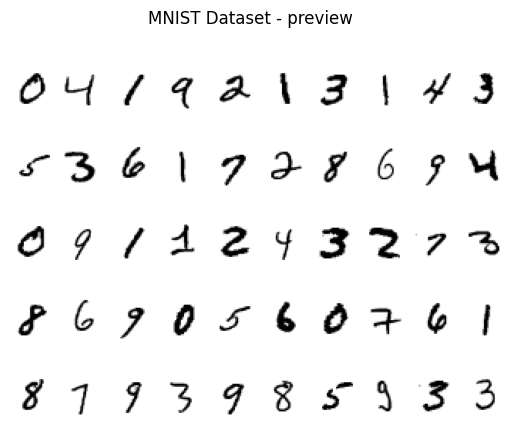

In [ ]:
# transforms 정의하기
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# 데이터셋 다운로드 및 생성
train_dataset = datasets.MNIST(
    root="mnist_data", train=True, transform=transform, download=True
)

valid_dataset = datasets.MNIST(root="mnist_data", train=False, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 불러온 MNIST 데이터 확인
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis("off")
    plt.imshow(train_dataset.data[index], cmap="gray_r")

fig.suptitle("MNIST Dataset - preview")

# 데이터셋 크기 출력
print(f"Train dataset size: {len(train_dataset)}")  # Train dataset size: 60000
print(
    f"Validation dataset size: {len(valid_dataset)}"
)  # Validation dataset size: 10000

20:57:09 ---  Epoch: 0	Train loss: 0.3018	Valid loss: 0.1232	Train accuracy: 96.40	Valid accuracy: 96.39
20:57:36 ---  Epoch: 1	Train loss: 0.1001	Valid loss: 0.0742	Train accuracy: 97.90	Valid accuracy: 97.64
20:58:05 ---  Epoch: 2	Train loss: 0.0661	Valid loss: 0.0675	Train accuracy: 98.33	Valid accuracy: 97.92
20:58:34 ---  Epoch: 3	Train loss: 0.0413	Valid loss: 0.0456	Train accuracy: 99.05	Valid accuracy: 98.48
20:59:02 ---  Epoch: 4	Train loss: 0.0346	Valid loss: 0.0450	Train accuracy: 99.19	Valid accuracy: 98.62
20:59:30 ---  Epoch: 5	Train loss: 0.0300	Valid loss: 0.0395	Train accuracy: 99.36	Valid accuracy: 98.63
20:59:58 ---  Epoch: 6	Train loss: 0.0218	Valid loss: 0.0389	Train accuracy: 99.51	Valid accuracy: 98.63
21:00:27 ---  Epoch: 7	Train loss: 0.0202	Valid loss: 0.0378	Train accuracy: 99.53	Valid accuracy: 98.66
21:00:55 ---  Epoch: 8	Train loss: 0.0191	Valid loss: 0.0374	Train accuracy: 99.58	Valid accuracy: 98.75
21:01:23 ---  Epoch: 9	Train loss: 0.0181	Valid loss: 0

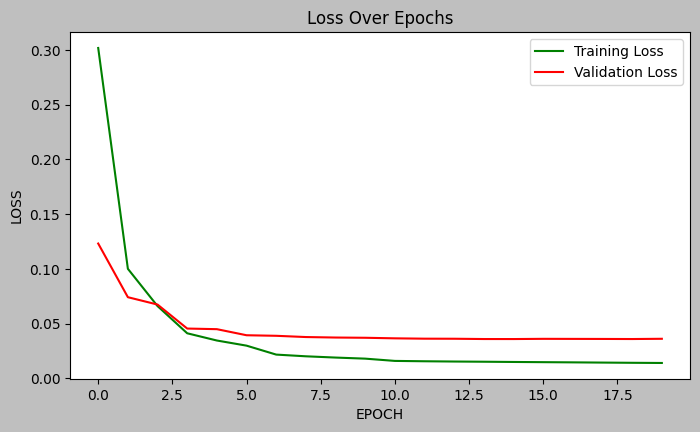

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_schedule(0))
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_loader, valid_loader, EPOCHS, DEVICE
)